In [2]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker,BioConservation

%matplotlib inline
import matplotlib
from scib_metrics.nearest_neighbors import NeighborsOutput

In [3]:
adata=sc.read("../../imporatant_process_data/4.12_wt_integrate_SCRAN_log1p_gene_filtered.h5ad")


In [4]:
import os

directory = "../processed_data/hypertune/"

files = os.listdir(directory)
varList=list()

for file in files:
    print(os.path.join(directory, file))
    var_name = "scANVI_" + file.split("/")[-1].split("_")[1] + "_" + file.split("/")[-1].split("_")[3]
    print(var_name)
    varList.append(var_name)

../processed_data/hypertune/gene_8000_latent_10_umap.h5ad
scANVI_8000_10
../processed_data/hypertune/gene_1500_latent_15_umap.h5ad
scANVI_1500_15
../processed_data/hypertune/gene_3000_latent_15_umap.h5ad
scANVI_3000_15
../processed_data/hypertune/gene_3000_latent_30_umap.h5ad
scANVI_3000_30
../processed_data/hypertune/gene_2000_latent_10_umap.h5ad
scANVI_2000_10
../processed_data/hypertune/gene_1000_latent_15_umap.h5ad
scANVI_1000_15
../processed_data/hypertune/gene_3000_latent_4_umap.h5ad
scANVI_3000_4
../processed_data/hypertune/gene_4000_latent_4_umap.h5ad
scANVI_4000_4
../processed_data/hypertune/gene_1500_latent_6_umap.h5ad
scANVI_1500_6
../processed_data/hypertune/gene_3000_latent_20_umap.h5ad
scANVI_3000_20
../processed_data/hypertune/gene_4000_latent_20_umap.h5ad
scANVI_4000_20
../processed_data/hypertune/gene_4000_latent_15_umap.h5ad
scANVI_4000_15
../processed_data/hypertune/gene_5000_latent_15_umap.h5ad
scANVI_5000_15
../processed_data/hypertune/gene_8000_latent_4_umap.h5ad


In [5]:
varList

['scANVI_8000_10',
 'scANVI_1500_15',
 'scANVI_3000_15',
 'scANVI_3000_30',
 'scANVI_2000_10',
 'scANVI_1000_15',
 'scANVI_3000_4',
 'scANVI_4000_4',
 'scANVI_1500_6',
 'scANVI_3000_20',
 'scANVI_4000_20',
 'scANVI_4000_15',
 'scANVI_5000_15',
 'scANVI_8000_4',
 'scANVI_5000_30',
 'scANVI_1500_20']

In [6]:
# update adata.obsm dictionary with the loaded data
for file in files:
    # extract the variable name from the file path
    var_name = "scANVI_" + file.split("/")[-1].split("_")[1] + "_" + file.split("/")[-1].split("_")[3]
    # read the data file
    data = sc.read(os.path.join(directory, file))
    # update the adata.obsm dictionary
    adata.obsm[var_name] = data.X

In [7]:
adata

AnnData object with n_obs × n_vars = 274670 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'K2', 'K6', 'K12', 'K24', 'K53', 'K2.1', 'K6.1', 'K12.1', 'K24.1', 'K53.1', 'K2.2', 'K6.2', 'K12.2', 'K24.2', 'K53.2', 'K2.3', 'K6.3', 'K12.3', 'K24.3', 'K53.3', 'C2', 'C6', 'C12', 'C21', 'C41', 'C2_named', 'C6_named', 'C12_named', 'C21_named', 'C41_named', 'K4', 'K11', 'K25', 'K57', 'C4', 'C9', 'C22', 'C42', 'C4_named', 'C9_named', 'C22_named', 'C42_named', 'K5', 'K19', 'K65', 'C17', 'C36', 'C5', 'C5_named', 'C17_named', 'C36_named', 'batch_atlas', 'size_factors', 'n_genes_by_coun

In [8]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsOutput


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))

In [45]:
indiceList=[]
for var in varList:
    _,indices=np.unique(adata.obsm[var], axis=0, return_index=True)
    indiceList.append(indices)
common_values = indiceList[0]
for arr in indiceList[1:]:
    common_values = np.intersect1d(common_values, arr)

In [46]:
adata=adata[common_values,]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 273479 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'K2', 'K6', 'K12', 'K24', 'K53', 'K2.1', 'K6.1', 'K12.1', 'K24.1', 'K53.1', 'K2.2', 'K6.2', 'K12.2', 'K24.2', 'K53.2', 'K2.3', 'K6.3', 'K12.3', 'K24.3', 'K53.3', 'C2', 'C6', 'C12', 'C21', 'C41', 'C2_named', 'C6_named', 'C12_named', 'C21_named', 'C41_named', 'K4', 'K11', 'K25', 'K57', 'C4', 'C9', 'C22', 'C42', 'C4_named', 'C9_named', 'C22_named', 'C42_named', 'K5', 'K19', 'K65', 'C17', 'C36', 'C5', 'C5_named', 'C17_named', 'C36_named', 'batch_atlas', 'size_factors', 'n_genes

In [40]:
varList[0:1]

['scANVI_1500_6']

In [52]:
biocons = BioConservation(isolated_labels=False)
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="coarse_label",
    embedding_obsm_keys=varList,
    bio_conservation_metrics=biocons,
    n_jobs=-1,
)


In [53]:
bm.benchmark()

Metrics:  50%|█████     | 5/10 [05:41<04:06, 49.29s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [06:01<04:26, 53.32s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [06:16<04:39, 55.99s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:51<04:15, 51.07s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:58<04:23, 52.75s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [06:04<04:27, 53.48s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:59<04:23, 52.64s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:41<04:05, 49.00s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:40<04:03, 48.76s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:  70%|███████   | 7/10 [09:42<03:51, 77.02s/it, Batch correction: pcr_comparison]    /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:58<04:22, 52.47s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:59<04:23, 52.60s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:58<04:22, 52.52s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [06:19<04:41, 56.22s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:36<03:57, 47.59s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:  70%|███████   | 7/10 [09:33<03:46, 75.46s/it, Batch correction: pcr_comparison]    /home/gilberthan/anaconda3/envs/scarches/lib/python3.8/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:55<04:20, 52.00s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:  50%|█████     | 5/10 [05:59<04:23, 52.65s/it, Batch correction: kbet_per_label]

INFO     Lepr-Progenitor consists of a single batch or is too small. Skip.                                         
INFO     Lepr_progenitor consists of a single batch or is too small. Skip.                                         
INFO     Pericytes consists of a single batch or is too small. Skip.                                               
INFO     Unclassified consists of a single batch or is too small. Skip.                                            



Embeddings: 100%|██████████| 16/16 [2:27:55<00:00, 554.70s/it]correction: pcr_comparison]

                                                                                         

In [63]:
common_values.dtype

dtype('int64')

In [54]:
bm.get_results()

,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,
scANVI_1500_6,0.128974,0.16295,0.421388,0.344985,0.333122,0.657411,1.0,0.403887,0.323156,0.543515,0.264574,0.376151
scANVI_1500_20,0.170508,0.367918,0.817299,0.929028,0.905995,0.145935,0.585028,0.932894,0.871979,0.688366,0.571189,0.61806
scANVI_3000_30,0.175022,0.239642,1.0,0.994821,1.0,0.029227,0.423185,0.973972,1.0,0.685277,0.602371,0.635533
scANVI_1000_15,0.0,0.117493,0.793662,0.825654,0.833684,0.260598,0.644545,0.762292,0.777842,0.655792,0.434202,0.522838
scANVI_3000_20,0.38605,0.11631,0.870516,0.95467,0.907589,0.081546,0.449104,0.985186,0.81997,0.648679,0.581887,0.608603
scANVI_4000_20,0.854316,0.232579,0.92633,0.966929,0.88375,0.069122,0.541252,0.981907,0.77949,0.651104,0.745039,0.707465
scANVI_2000_10,0.940043,0.765125,0.726655,0.764816,0.586479,0.312128,0.571781,0.809569,0.4047,0.536931,0.79916,0.694268
scANVI_8000_4,0.518057,0.161249,0.049459,0.0,0.0,0.981564,0.112029,0.127778,0.074046,0.259083,0.182191,0.212948
scANVI_4000_4,0.294136,0.06351,0.0,0.055162,0.203411,0.932221,0.0,0.0,0.0,0.227126,0.103202,0.152772


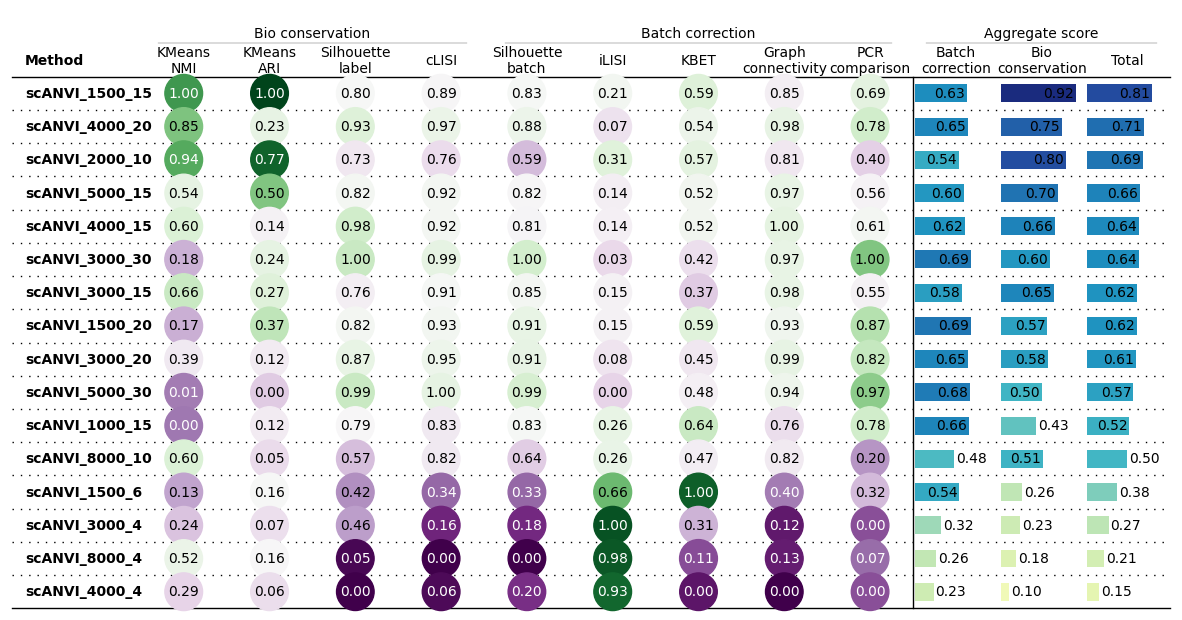

<Figure size 640x480 with 0 Axes>

In [57]:
bm.plot_results_table()
matplotlib.pyplot.savefig("../result/hypertune/4.15_hypertune_metric.pdf")

In [58]:
df = bm.get_results(min_max_scale=False)
print(df)
df.to_csv("../result/4.15_best_config.csv")

                      KMeans NMI        KMeans ARI  Silhouette label  \
Embedding                                                              
scANVI_1500_6           0.367853          0.183657          0.430953   
scANVI_1500_20          0.369468           0.20179          0.456907   
scANVI_3000_30          0.369643          0.190442          0.468884   
scANVI_1000_15          0.362837          0.179636          0.455358   
scANVI_3000_20           0.37785          0.179531          0.460396   
scANVI_4000_20           0.39606          0.189817          0.464055   
scANVI_2000_10          0.399394          0.236929          0.450965   
scANVI_8000_4           0.382984          0.183507          0.406571   
scANVI_4000_4           0.374276           0.17486          0.403329   
scANVI_1500_15          0.401726          0.257707          0.455482   
scANVI_5000_15          0.383996          0.213851          0.456912   
scANVI_3000_15           0.38851           0.19311          0.45

In [61]:
np.savetxt("../../unimportant_processed_data/4.15_wt_integrate_index.csv",common_values,delimiter=",")

In [64]:
adata

AnnData object with n_obs × n_vars = 273479 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Cre', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'K2', 'K6', 'K12', 'K24', 'K53', 'K2.1', 'K6.1', 'K12.1', 'K24.1', 'K53.1', 'K2.2', 'K6.2', 'K12.2', 'K24.2', 'K53.2', 'K2.3', 'K6.3', 'K12.3', 'K24.3', 'K53.3', 'C2', 'C6', 'C12', 'C21', 'C41', 'C2_named', 'C6_named', 'C12_named', 'C21_named', 'C41_named', 'K4', 'K11', 'K25', 'K57', 'C4', 'C9', 'C22', 'C42', 'C4_named', 'C9_named', 'C22_named', 'C42_named', 'K5', 'K19', 'K65', 'C17', 'C36', 'C5', 'C5_named', 'C17_named', 'C36_named', 'batch_atlas', 'size_factors', 'n_genes_by_coun